Log: Inicjalizacja wczytywania zbiorów treningowych i testowych...
Log: Dane wczytane poprawnie. Wymiary zbioru treningowego: (1076280, 39), testowego: (269070, 39)
Log: Ograniczono przestrzeń zmiennych wejściowych do: ['fico_score']
Log: Rozpoczęto proces trenowania modelu Regresji Logistycznej...
Log: Proces uczenia modelu zakończony.

--- WYNIKI MODELU A (BENCHMARK: FICO ONLY) ---
AUC Score (Obszar pod krzywą): 0.5934
Gini Coefficient:              0.1869


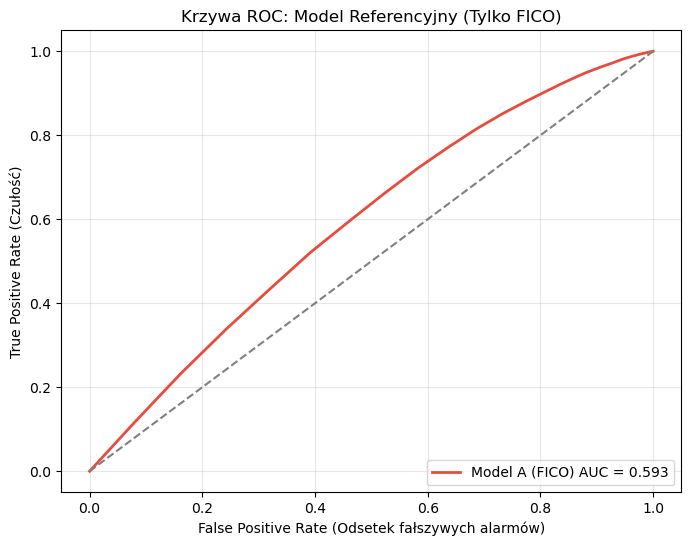


Log: Wektor prawdopodobieństw modelu A zapisano w pliku 'probs_model_a.npy'.
 Procedura budowy modelu referencyjnego zakończona.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import os

# --- 1. IMPORT DANYCH PRZYGOTOWANYCH W ETAPIE 3 ---
print("Log: Inicjalizacja wczytywania zbiorów treningowych i testowych...")

# Wczytanie danych przetworzonych
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

print(f"Log: Dane wczytane poprawnie. Wymiary zbioru treningowego: {X_train.shape}, testowego: {X_test.shape}")

# --- 2. DEFINICJA MODELU REFERENCYJNEGO (BENCHMARK) ---
# Model A korzysta TYLKO z jednej zmiennej: 'fico_score'.
# Celem jest symulacja procesu decyzyjnego opartego wyłącznie na scoringu biura kredytowego.

features_benchmark = ['fico_score']

X_train_fico = X_train[features_benchmark]
X_test_fico = X_test[features_benchmark]

print(f"Log: Ograniczono przestrzeń zmiennych wejściowych do: {features_benchmark}")

# --- 3. TRENING MODELU (REGRESJA LOGISTYCZNA) ---
# Wykorzystanie regresji logistycznej jako standardu rynkowego dla prostych kart skoringowych.
# Parametr class_weight='balanced' uwzględnia nierównowagę klas.

print("Log: Rozpoczęto proces trenowania modelu Regresji Logistycznej...")
model_a = LogisticRegression(random_state=42, class_weight='balanced')
model_a.fit(X_train_fico, y_train)
print("Log: Proces uczenia modelu zakończony.")

# --- 4. EWALUACJA SKUTECZNOŚCI (WALIDACJA) ---
# Generowanie prawdopodobieństwa wystąpienia zdarzenia (Default) dla zbioru testowego.
# Wybór kolumny [:, 1] odpowiadającej klasie pozytywnej (1).

probs_a = model_a.predict_proba(X_test_fico)[:, 1]

# Obliczenie metryk oceny: AUC (Area Under ROC Curve) oraz współczynnika Giniego.
auc_score = roc_auc_score(y_test, probs_a)
gini_score = 2 * auc_score - 1

print(f"\n--- WYNIKI MODELU A (BENCHMARK: FICO ONLY) ---")
print(f"AUC Score (Obszar pod krzywą): {auc_score:.4f}")
print(f"Gini Coefficient:              {gini_score:.4f}")

# --- 5. WIZUALIZACJA I ARCHIWIZACJA WYNIKÓW ---

# Generowanie danych do krzywej ROC
fpr, tpr, thresholds = roc_curve(y_test, probs_a)

# Rysowanie wykresu
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'Model A (FICO) AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Linia losowa
plt.xlabel('False Positive Rate (Odsetek fałszywych alarmów)')
plt.ylabel('True Positive Rate (Czułość)')
plt.title('Krzywa ROC: Model Referencyjny (Tylko FICO)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Weryfikacja katalogu i zapis wykresu
if not os.path.exists('../figures'):
    os.makedirs('../figures')
plt.savefig('../figures/04_roc_model_a.png')
plt.show()

# Zapis wektora prawdopodobieństw (niezbędne do wykresu porównawczego w kolejnym etapie)
np.save('../data/probs_model_a.npy', probs_a)
print("\nLog: Wektor prawdopodobieństw modelu A zapisano w pliku 'probs_model_a.npy'.")
print(" Procedura budowy modelu referencyjnego zakończona.")

**Wyniki ilościowe**

Model referencyjny, oparty wyłącznie na zmiennej fico_score, osiągnął na zbiorze testowym wskaźnik AUC na poziomie 0,5934. Odpowiada to współczynnikowi Giniego wynoszącemu 0,1869.

**Interpretacja krzywej ROC**

Analiza wykresu krzywej ROC (Rysunek 4) wskazuje, że zdolność modelu do poprawnej klasyfikacji kredytobiorców jest niska. Krzywa przebiega w niewielkiej odległości od linii przekątnej (reprezentującej losowy wybór, dla którego AUC = 0,5), co sugeruje, że sama punktacja FICO jest niewystarczającym predyktorem niewypłacalności wewnątrz grupy klientów już zweryfikowanych (tj. tych, którzy przeszli wstępną selekcję).

**Wnioski badawcze**

 Uzyskany wynik (AUC < 0,60) potwierdza, że w segmencie pożyczek społecznościowych (P2P), gdzie wstępna selekcja eliminuje wnioskodawców o najniższym scoringu, zmienna FICO traci swoją moc różnicującą. Oznacza to, że opieranie decyzji kredytowej wyłącznie na historii kredytowej prowadzi do skuteczności tylko nieznacznie wyższej od losowego zgadywania. Wynik ten stanowi silne uzasadnienie dla konieczności włączenia do modelu zmiennych behawioralnych i dochodowych (Model B).